In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

In [2]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '/sciclone/scr10/dchendrickson01/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [3]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


files = ['230418 recording1.csv','230419 recording1.csv','230420 recording1.csv','230421 recording1.csv',
         '230418 recording2.csv','230419 recording2.csv','230420 recording2.csv','230421 recording2.csv']

#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def SmoothMoves(file):
    #    if file[-3:] =='csv':
    ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
    SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothX -= np.average(SmoothX)
    SmoothY -= np.average(SmoothY)
    SmoothZ -= np.average(SmoothZ)
    MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
    return MoveMatrix
    #else:
    #    pass

In [4]:
LoopFiles = 8
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1



st = ti()

Moves = []

for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    #Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    Results = Parallel(n_jobs=LoopFiles)(delayed(SmoothMoves)(file) for file in tfiles)
    #Results =[]
    #for file in tfiles:
    #    Results.append(DeviationVelocity(file))
    #    print(file, (ti()-st)/60.0)
    for result in Results:
        Moves.append(result)
    print(k, (ti()-st)/60.0)
      

0 2.1839353402455646


In [5]:
  
TimeSteps = 250
StepSize = 15
PredictSize = 25
Features = 3
Features = np.shape(Moves[0])[0]

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, s_step = 1, y_steps = 1):
    X, y = list(), list()
    Steps_to_take = int(len(sequences) / s_step)
    for j in range(Steps_to_take):
        i = j * s_step
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:end_ix+y_steps :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
Sequences = []
Outputs = []
for move in Moves:
    Seq, Out = split_sequences(move.T,TimeSteps,StepSize,PredictSize)
    Sequences.append(Seq)
    Outputs.append(Out)
    

MoveSegments = []
for seq in Sequences:
    for mv in seq:
        MoveSegments.append(mv)
NextDataPoint = []
for out in Outputs:
    for pt in out:
        NextDataPoint.append(pt) #np.reshape(pt,(PredictSize,3)))

print('Move Segments ', len(MoveSegments),(ti()-st)/60.0)

/local/scr/dchendrickson01/TMPDIR/ipykernel_23428/1740964293.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


Move Segments  8569639 3.5829866846402485


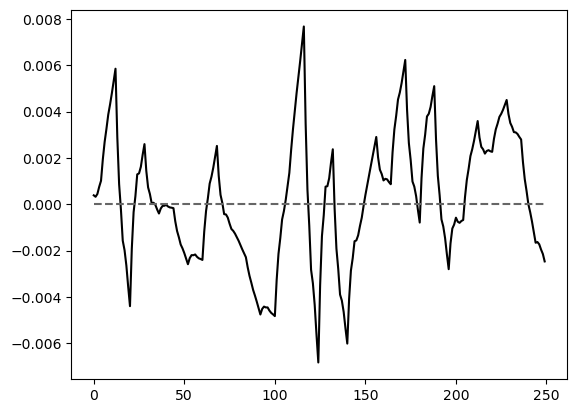

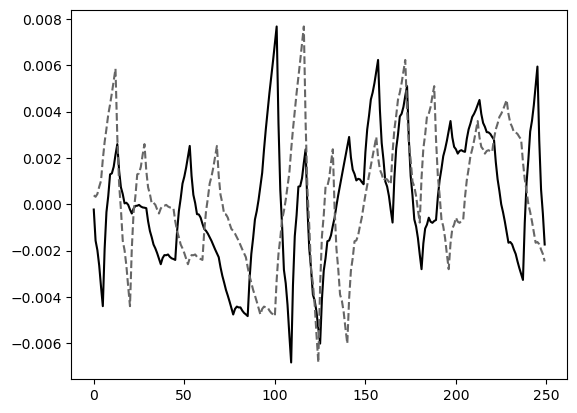

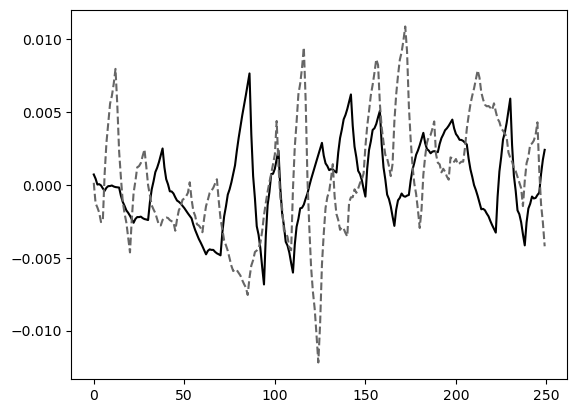

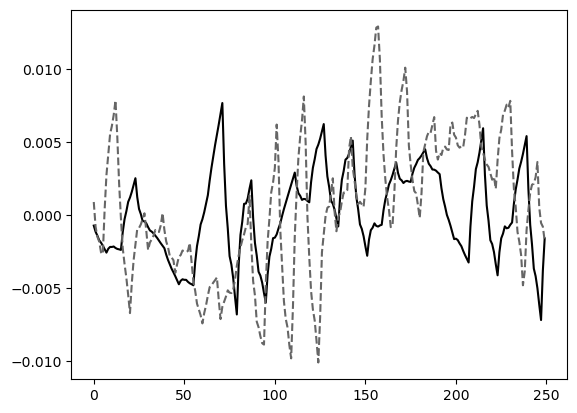

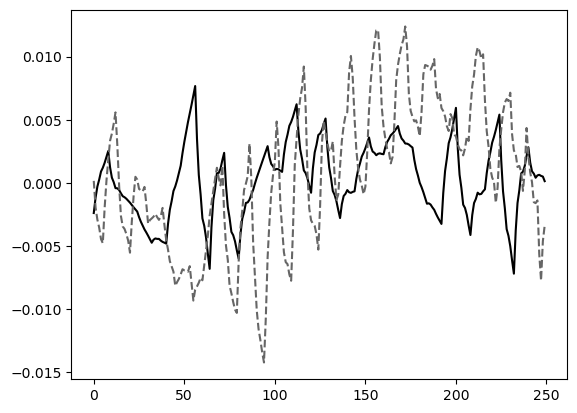

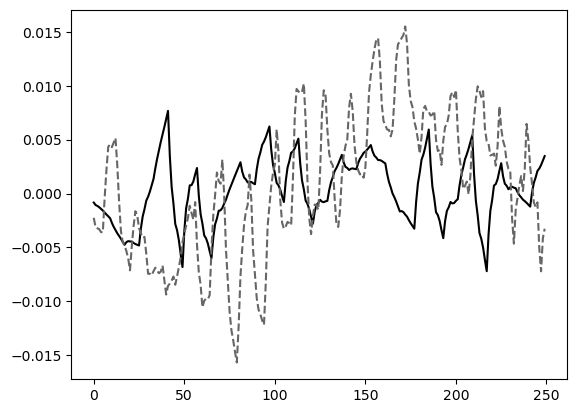

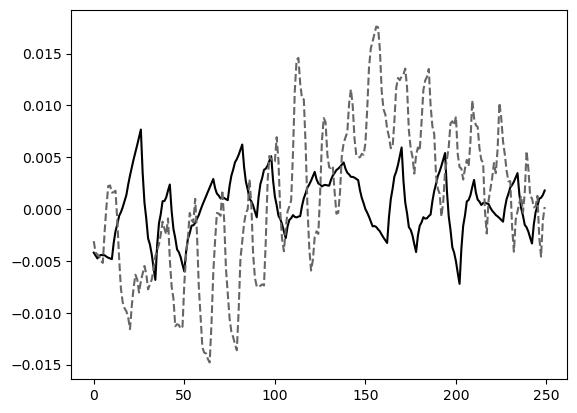

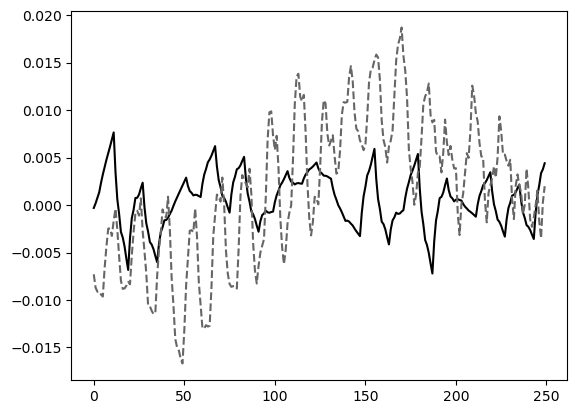

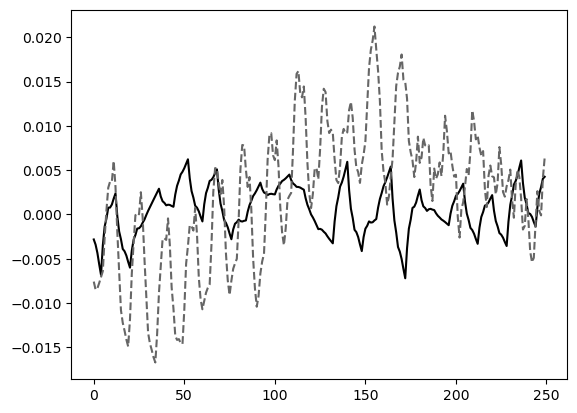

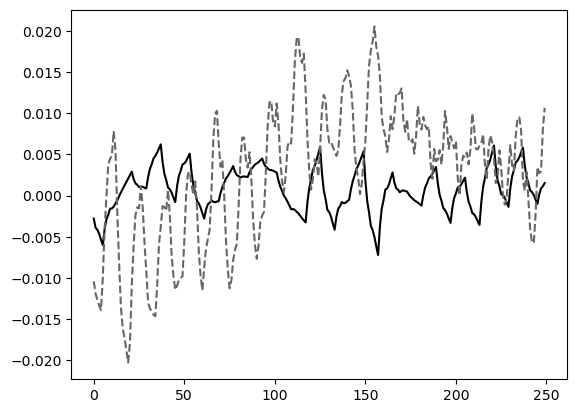

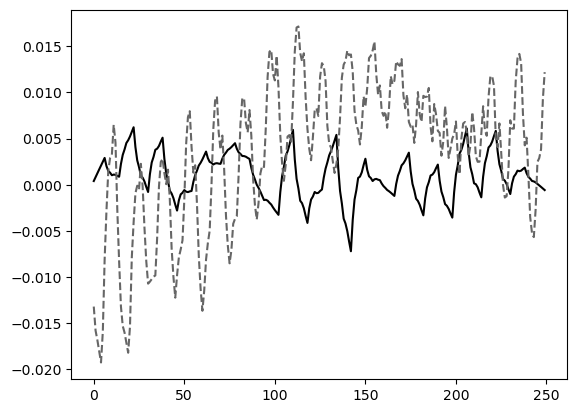

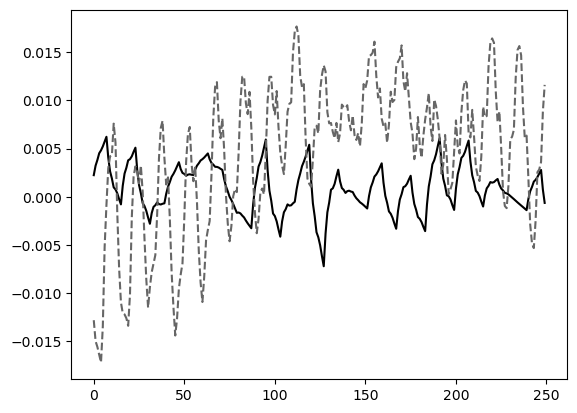

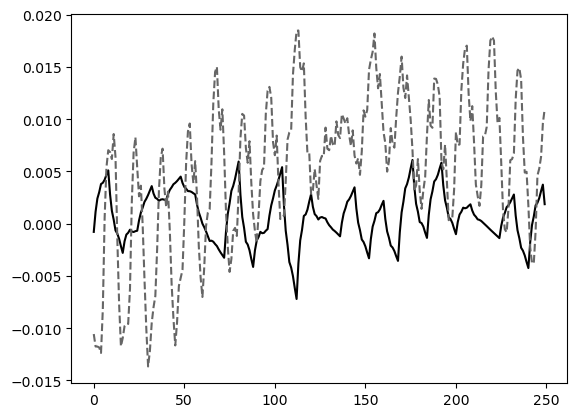

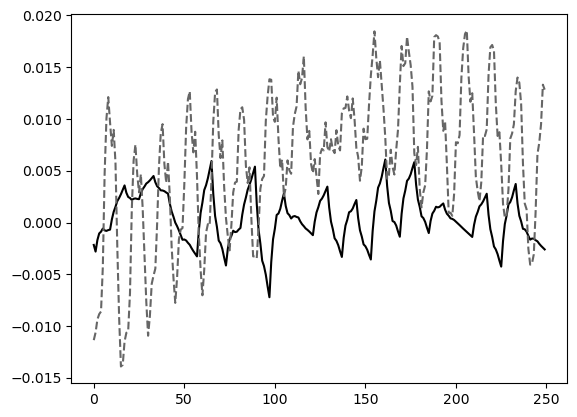

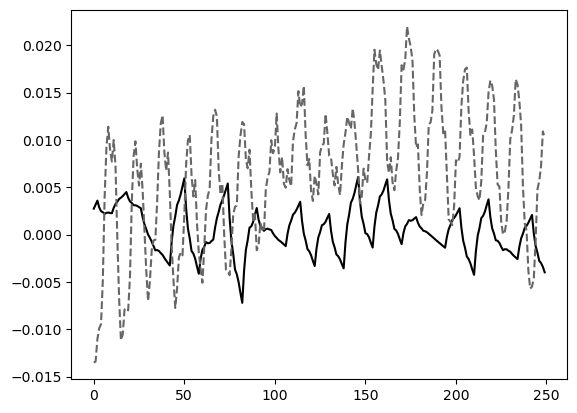

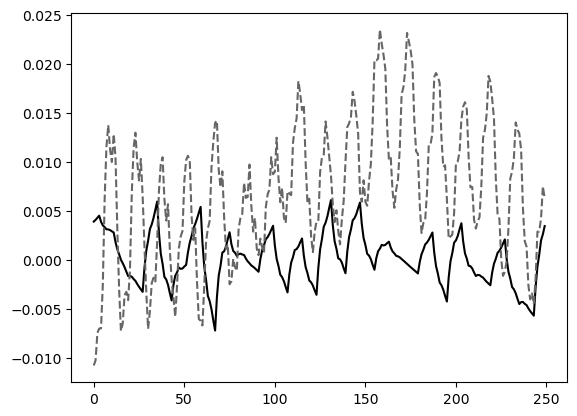

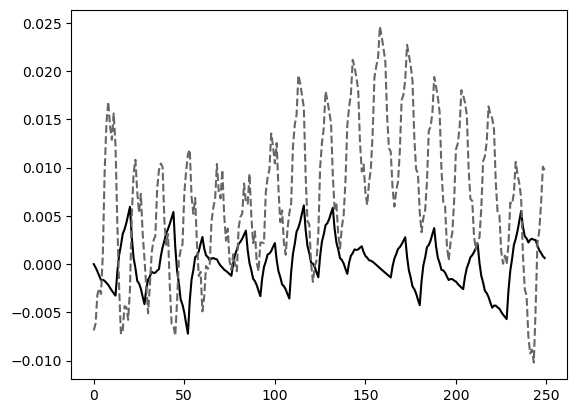

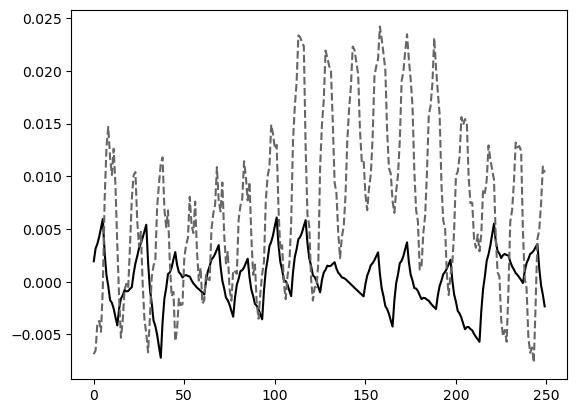

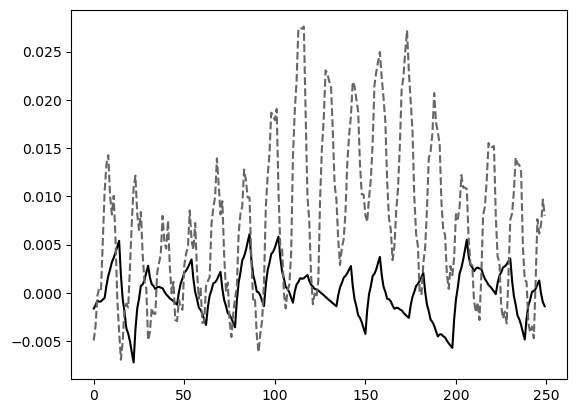

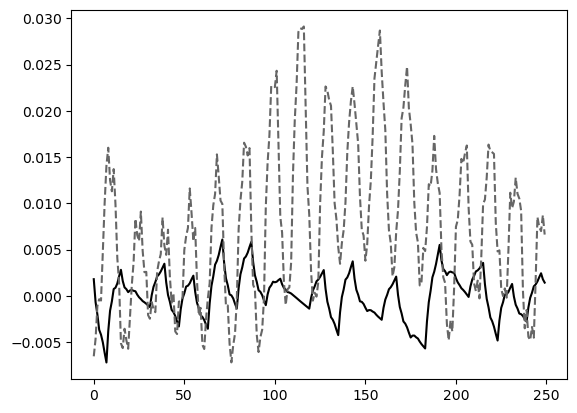

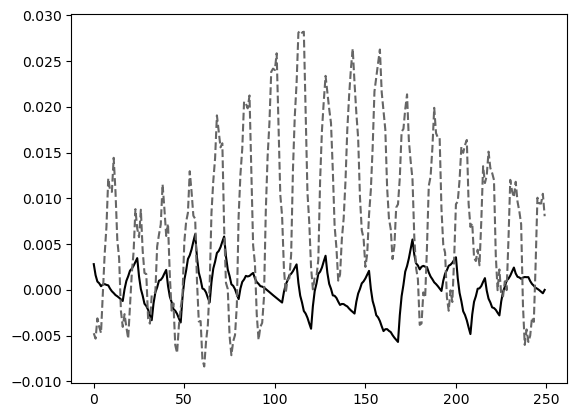

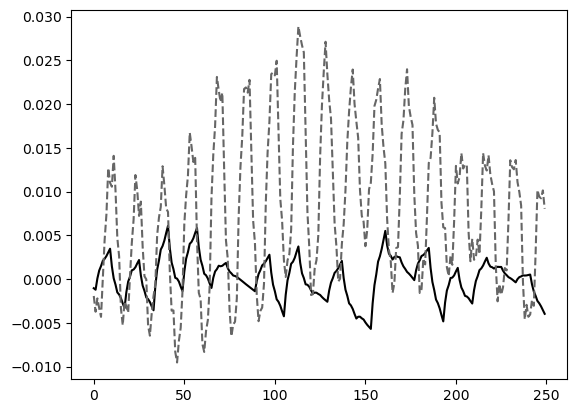

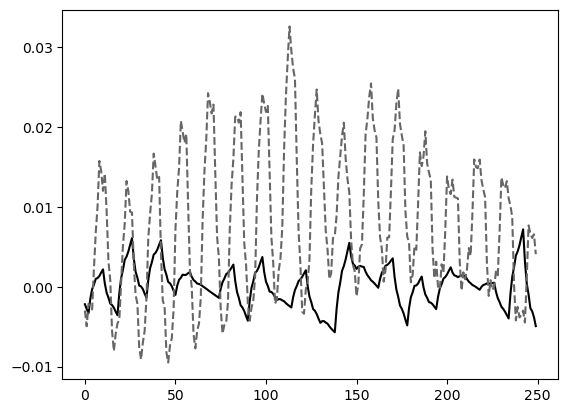

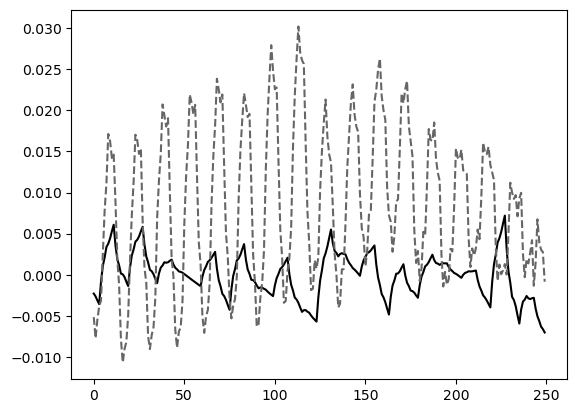

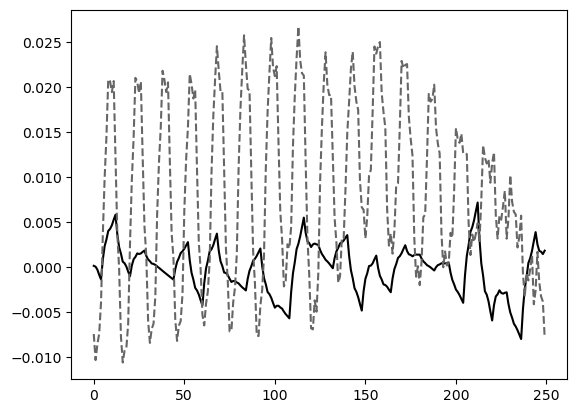

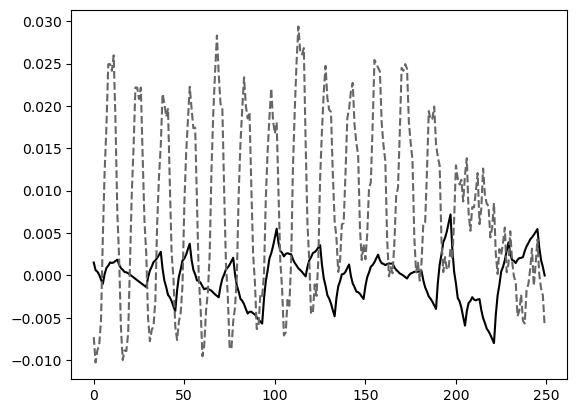

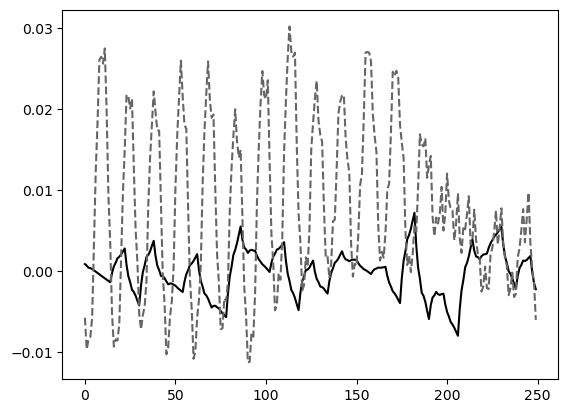

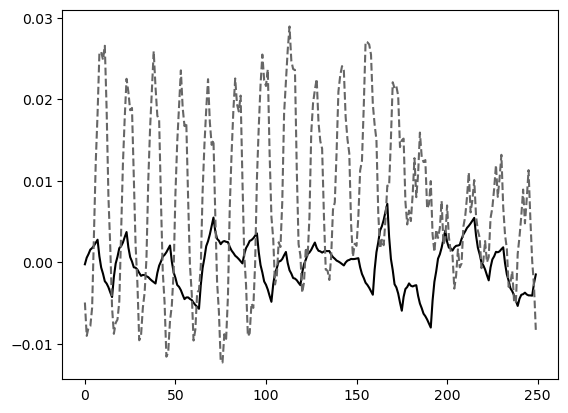

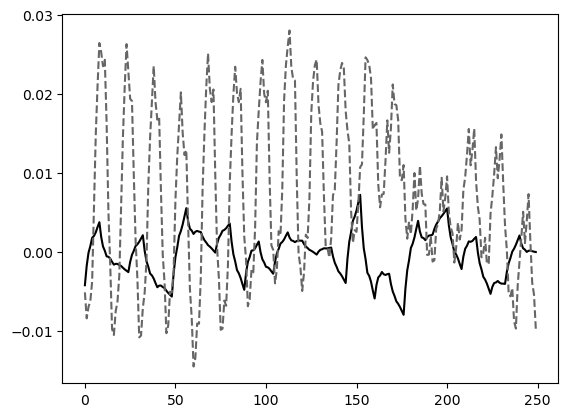

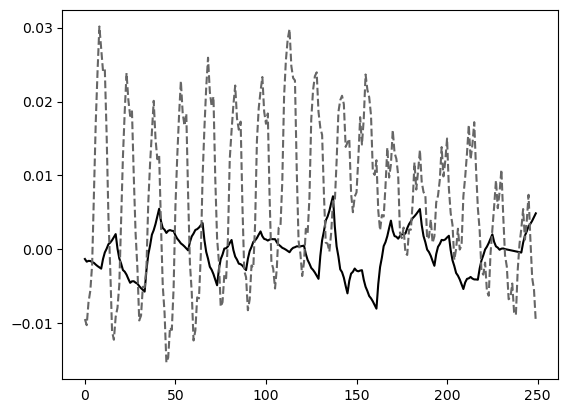

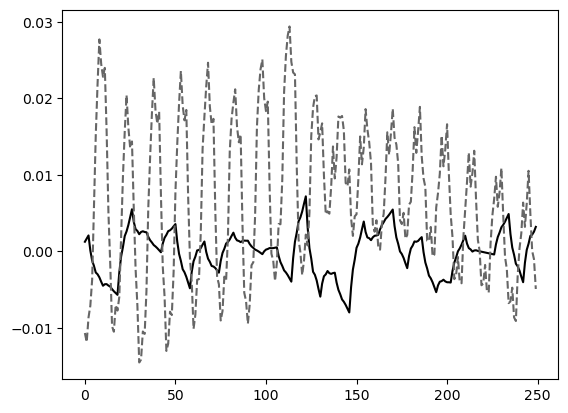

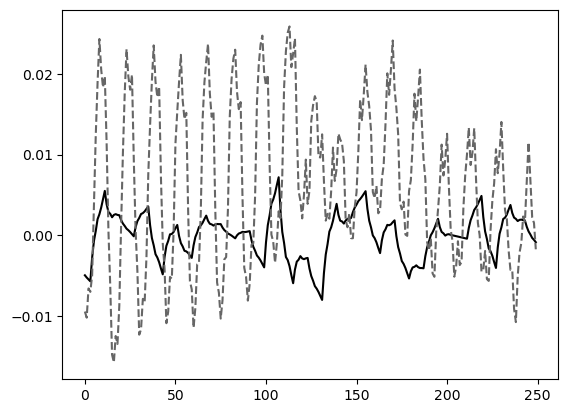

In [13]:
fig = plt.figure()

xdifs = np.zeros(len(MoveSegments[0]))
ydifs = np.zeros(len(MoveSegments[0]))
zdifs = np.zeros(len(MoveSegments[0]))

for i in range(32):
    seg = MoveSegments[99+i]
    xs = np.zeros(len(seg))
    ys = np.zeros(len(seg))
    zs = np.zeros(len(seg))
    
    xdif = xs - seg[:,0] 
    #xdif *= xdif
    
    ydif = ys - seg[:,1]
    #ydif *= ydif
    
    zdif = zs - seg[:,2]
    #zdif *= zdif
    
    plt.plot(xdif)
    plt.plot(xdifs)
    
    plt.show()
    
    xdifs += xdif
    

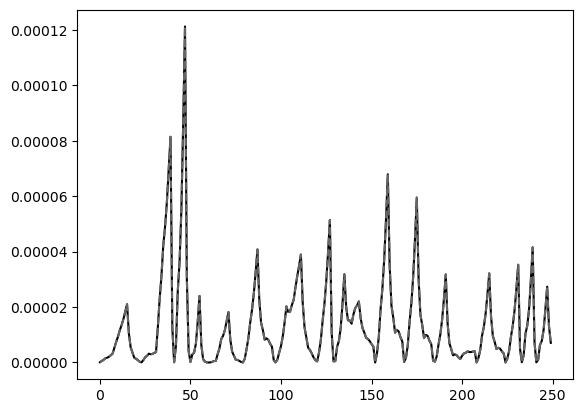

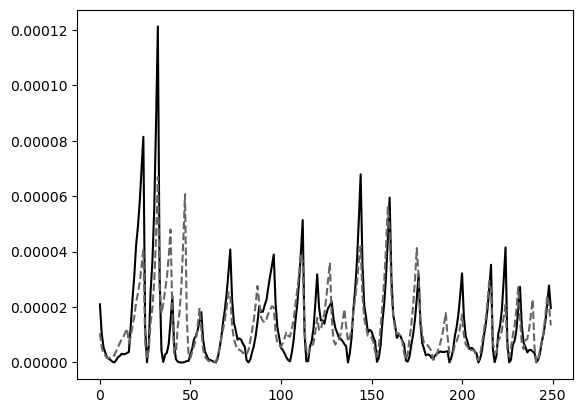

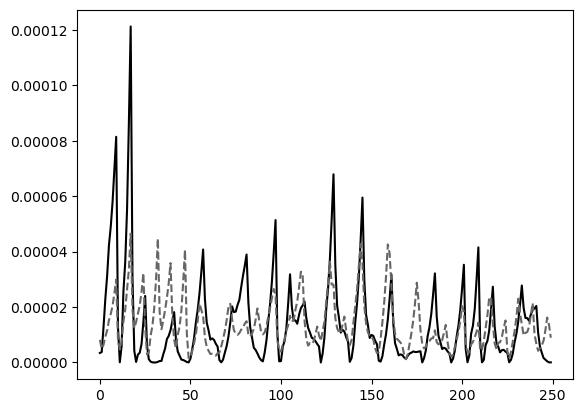

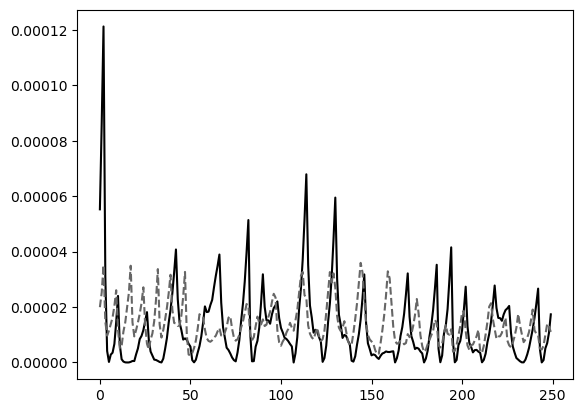

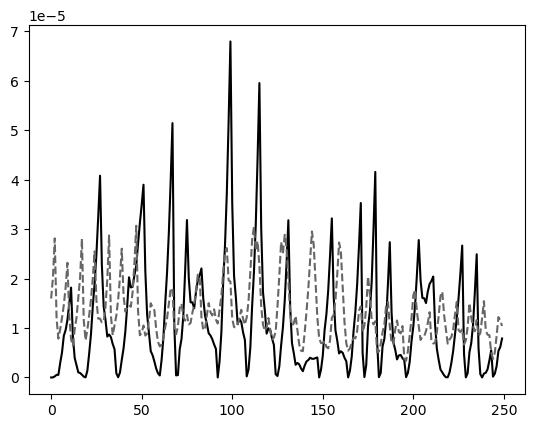

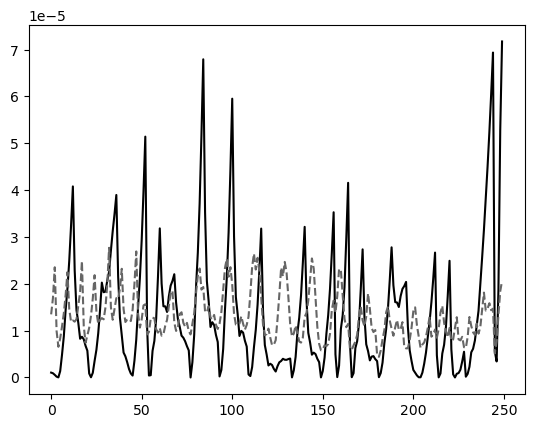

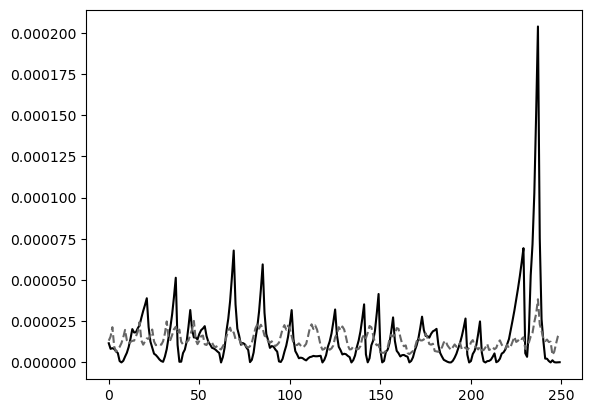

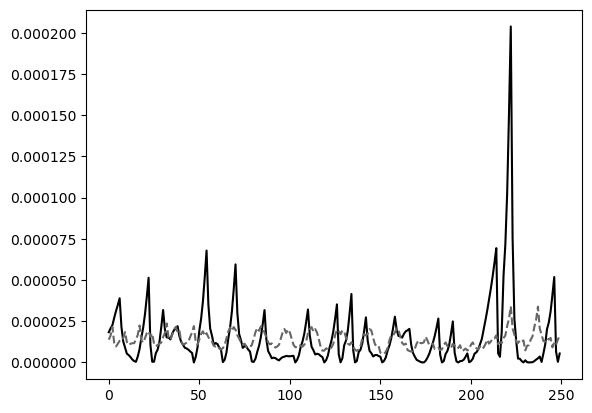

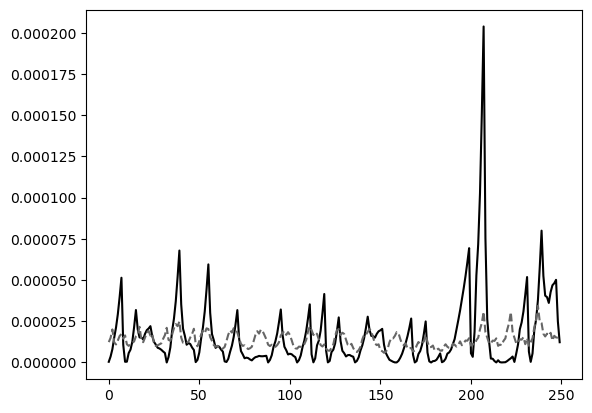

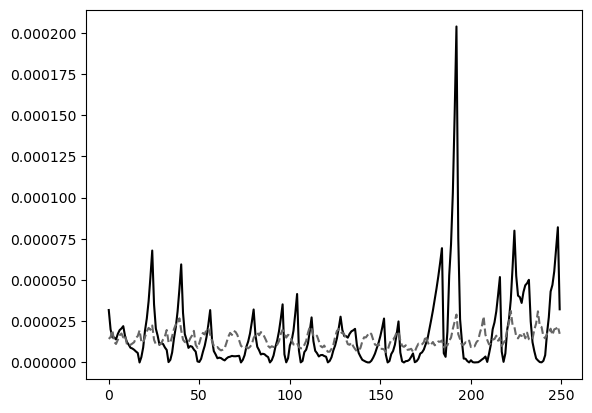

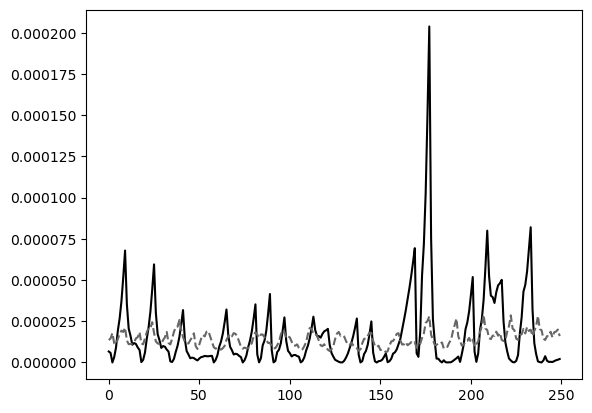

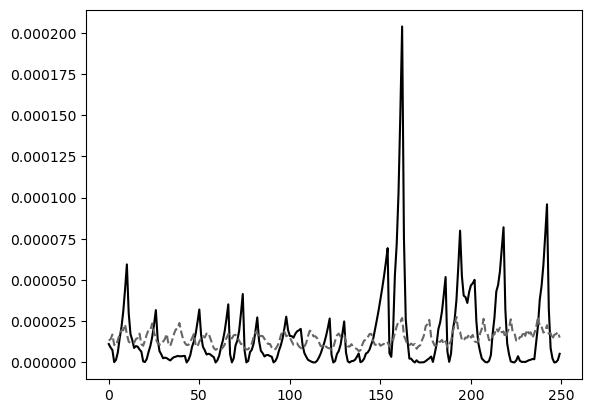

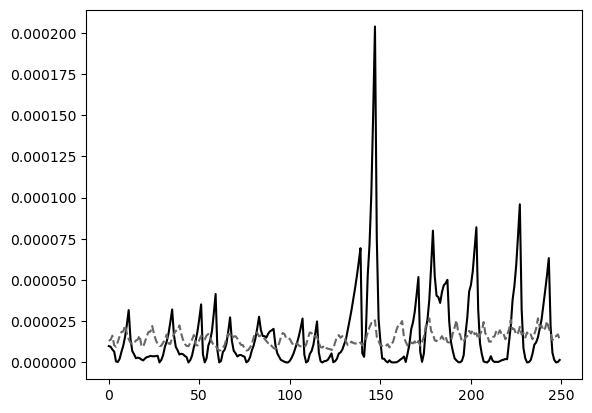

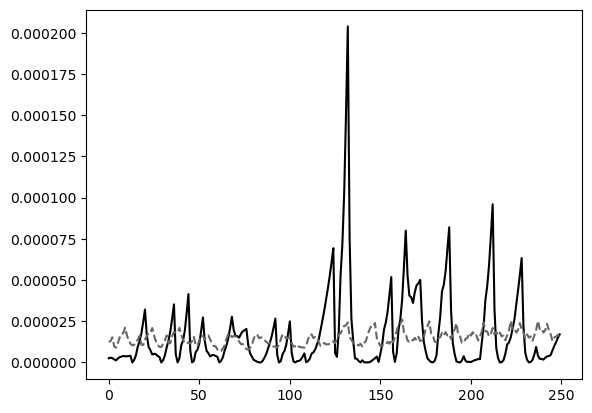

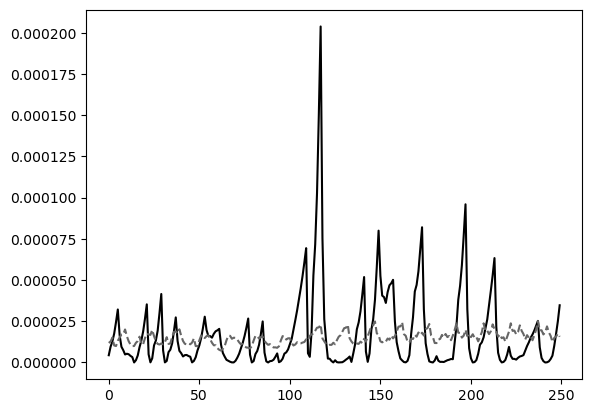

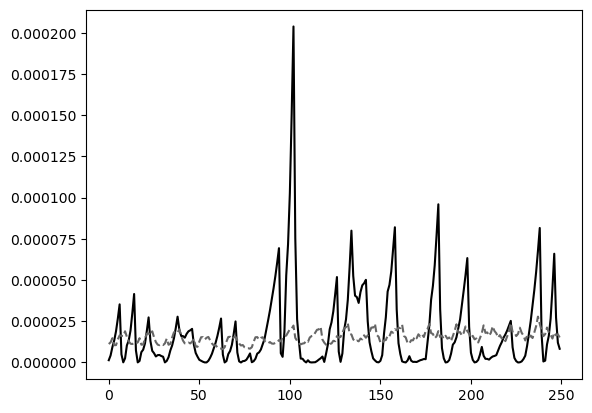

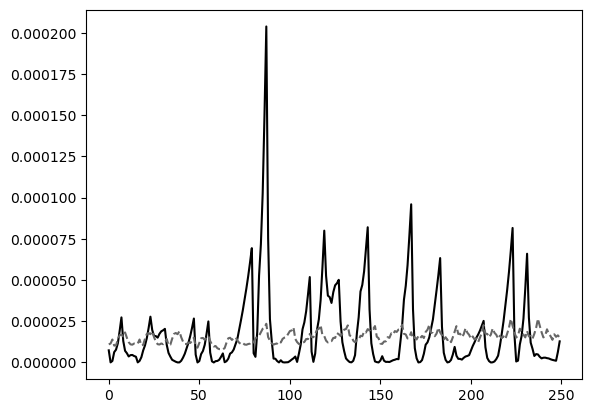

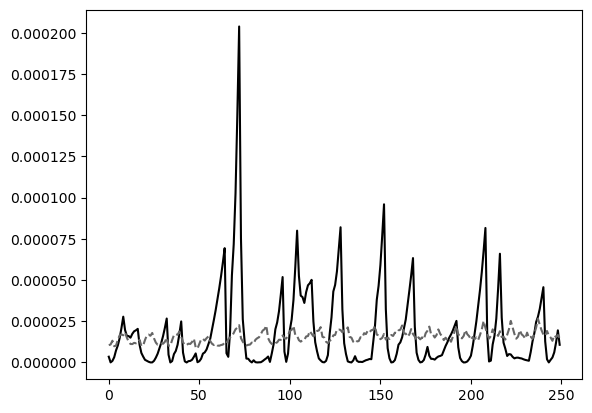

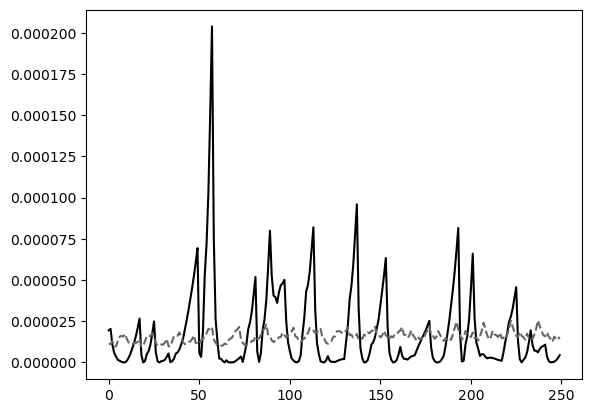

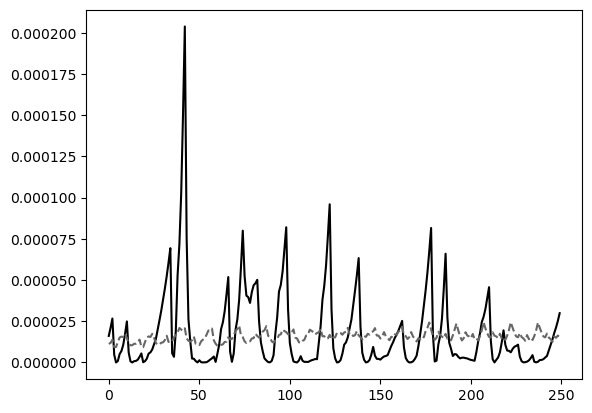

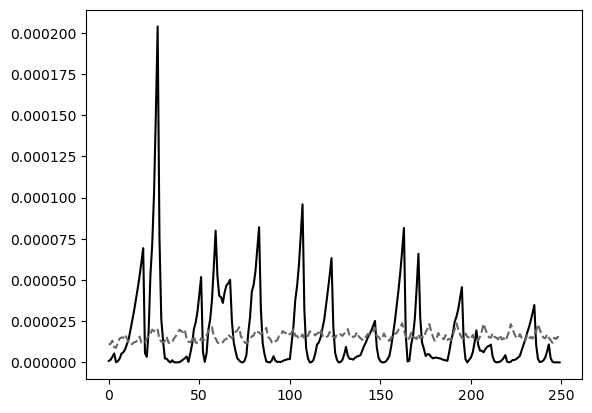

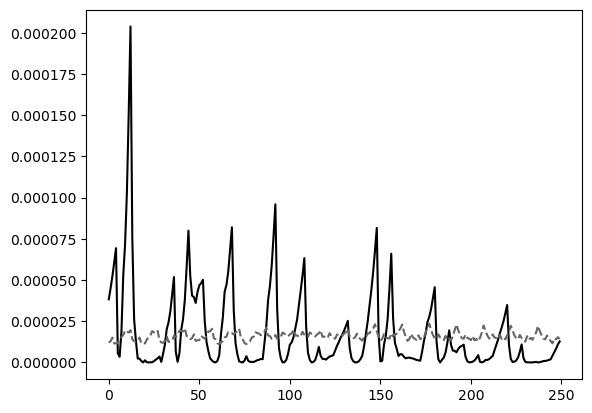

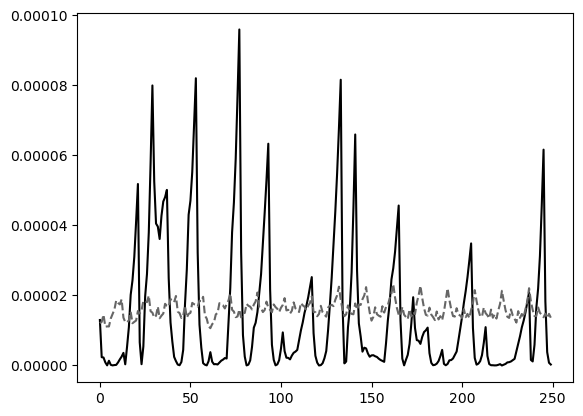

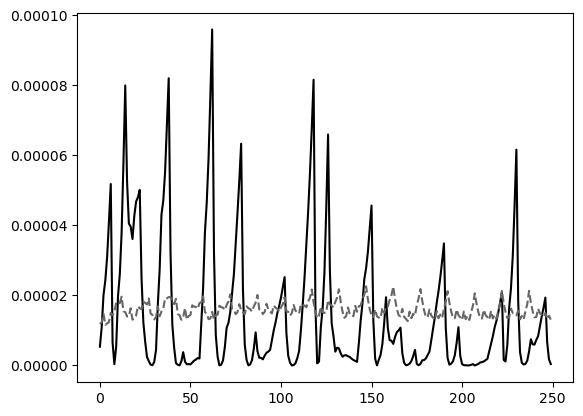

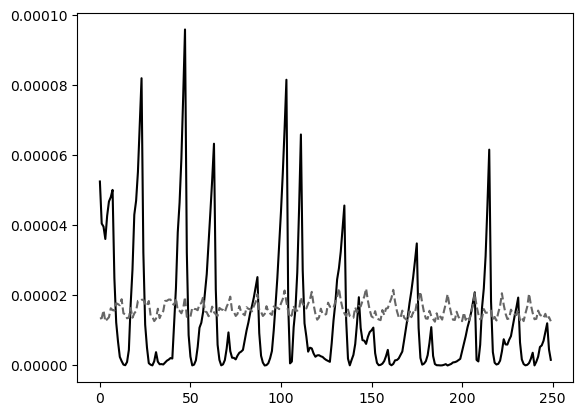

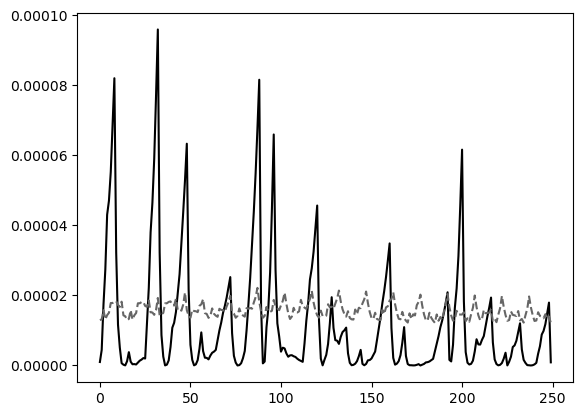

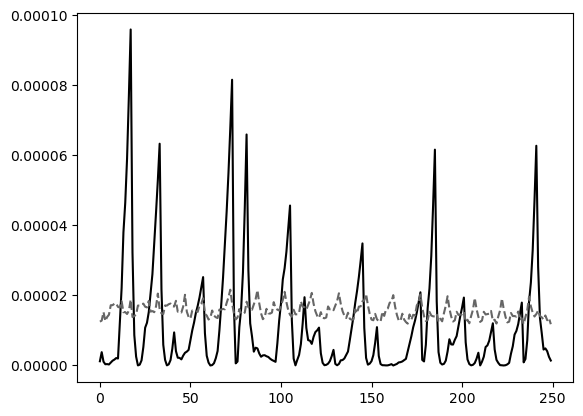

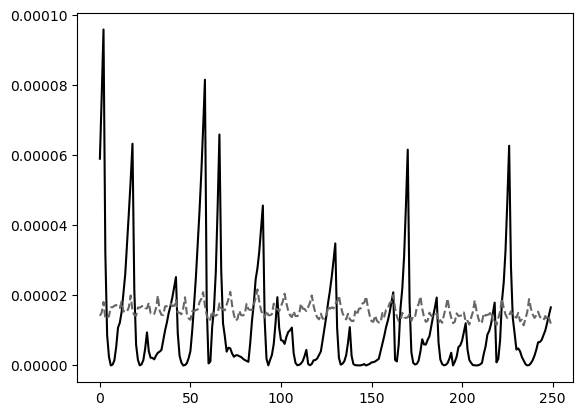

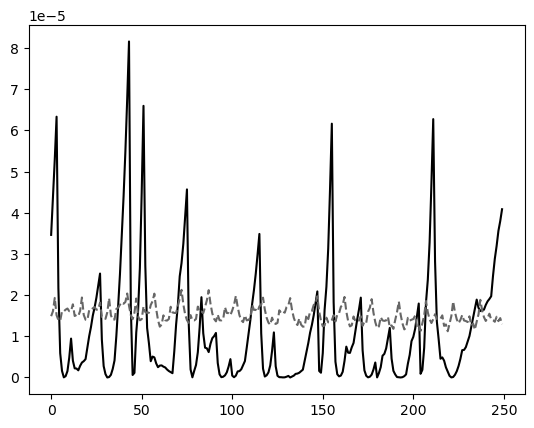

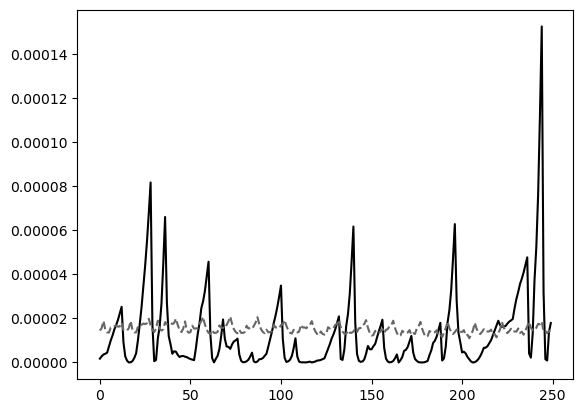

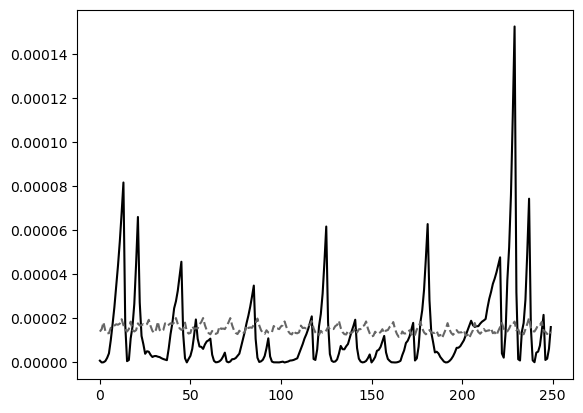

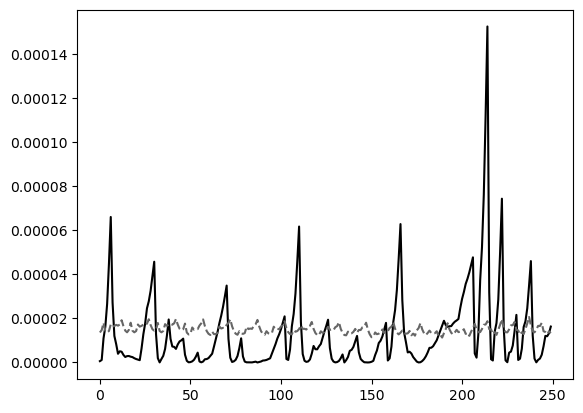

In [17]:
fig = plt.figure()

xdifs = np.zeros(len(MoveSegments[0]))
ydifs = np.zeros(len(MoveSegments[0]))
zdifs = np.zeros(len(MoveSegments[0]))

for i in range(32):
    seg = MoveSegments[564654+i]
    xs = np.zeros(len(seg))
    ys = np.zeros(len(seg))
    zs = np.zeros(len(seg))
    
    xdif = xs - seg[:,0] 
    xdif *= xdif
    
    ydif = ys - seg[:,1]
    #ydif *= ydif
    
    zdif = zs - seg[:,2]
    #zdif *= zdif

    xdifs += xdif

    
    plt.plot(xdif)
    plt.plot(xdifs / (i+1))
    
    plt.show()
    
    